# PSD analysis of spikes 
* 2/10/24 setup

In [5]:
import sys
import json
import matplotlib.pyplot as plt
from os.path import join, dirname
import pandas as pd
import numpy as np
import seaborn as sns

from scipy.fftpack import fft
from scipy.stats import zscore
from scipy.interpolate import interp1d
from scipy.stats import t

sys.path.append("/home/gergely/code/sleep/src")

from imaging_data_class import ImagingData
from suite2p_class import Suite2p as s2p
import imaging_data_class as idc
import behavior_class as bc

sys.path.append("/home/gergely/code/sleep/notebooks/neuropil_analysis")

import neuropil as npl

### Dendritic recorrdings

In [6]:
mice = ["140502_5", "140302_3"]
sima_folders = [
    "/data2/gergely/invivo_DATA/sleep/140502_5/1_16/TSeries-01162024-0853_dendrite-001/TSeries-01162024-0853_dendrite-001.sima",
    "/data2/gergely/invivo_DATA/sleep/140502_5/1_17/TSeries-01172024-0745_dendrites-001/TSeries-01172024-0745_dendrites-001.sima",
    "/data2/gergely/invivo_DATA/sleep/140302_3/1_18/TSeries-01182024-0805-003/TSeries-01182024-0805-003.sima",
]

#### Spikes

In [7]:
spks = []
for folder in sima_folders:
    s2p_data = s2p(join(folder, "suite2p"))
    spikes = s2p_data.get_spikes()
    # z scoring
    n_neurons, n_time = spikes.shape
    spks.append(zscore(spikes, axis=1))

mob_immobs = []
for folder in sima_folders:
    data = join(folder, "behavior", "mobility_immobility.json")
    with open(data, "r") as f:
        mob_immobs.append(np.array(json.load(f)))

In [8]:
moving_spikes = []
immobile_spikes = []
for spk, mob_immob in zip(spks, mob_immobs):
    moving_spikes.append(spk[:, mob_immob == 1])
    immobile_spikes.append(spk[:, ~mob_immob == 1])

In [9]:
# Initialize the dictionaries with lists to store multiple arrays
moving_data = {"freq": [], "psd": []}
notmoving_data = {"freq": [], "psd": []}

# Assuming npl.calculate_psd is your function to calculate PSD
# And assuming moving_spikes and immobile_spikes are iterables of your data arrays

for mov_data in moving_spikes:
    freq, psd = npl.calculate_psd(mov_data, 10, (0, 0.1))
    moving_data["freq"].append(freq)
    moving_data["psd"].append(np.mean(psd, axis=0))

for imm_data in immobile_spikes:
    freq, psd = npl.calculate_psd(imm_data, 10, (0, 0.1))
    notmoving_data["freq"].append(freq)
    notmoving_data["psd"].append(np.mean(psd, axis=0))

In [10]:
def plot_psd_from_dict(
    data_dict,
    ax=None,
    title="PSD Plot",
    xlabel="Frequency (Hz)",
    ylabel="Power Spectral Density",
):
    """
    Plot PSD data stored in a dictionary.

    Parameters:
    - data_dict: Dictionary with "freq" and "psd" keys, where "freq" is a list of frequency arrays,
      and "psd" is a list of corresponding PSD arrays.
    - ax: Optional; matplotlib.axes.Axes object for plotting. If None, a new figure and axes are created.
    - title: Title of the plot.
    - xlabel: Label for the x-axis.
    - ylabel: Label for the y-axis.
    """
    if ax is None:
        fig, ax = plt.subplots()

    # Assuming each "freq" and "psd" pair should be plotted together
    for freq, psd in zip(data_dict["freq"], data_dict["psd"]):
        ax.plot(freq, psd)

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_yscale("log")
    ax.grid(True)

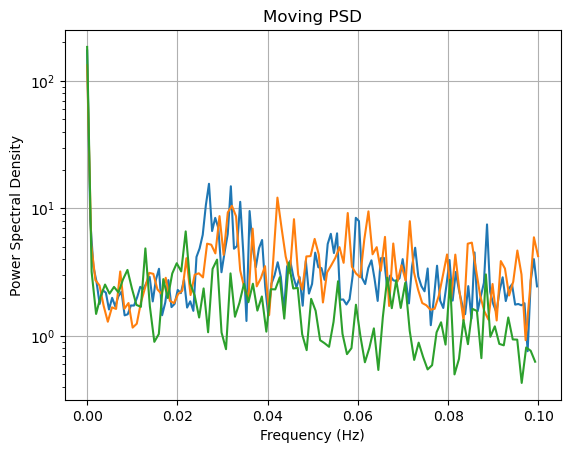

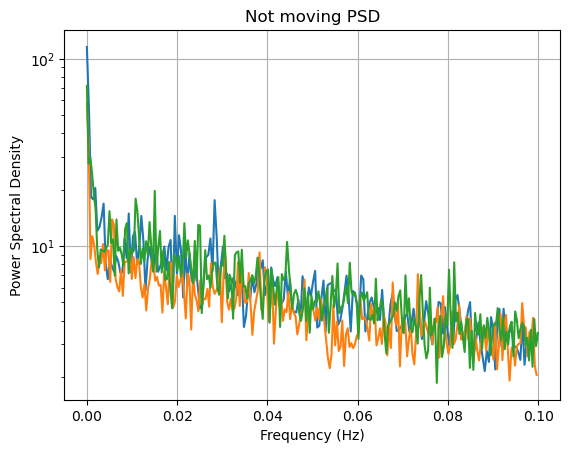

In [67]:
plot_psd_from_dict(moving_data, title="Moving PSD")
plot_psd_from_dict(notmoving_data, title="Not moving PSD")

Need to resample the psd-s so the frequency axis is the same for all the recordings.

In [11]:
def resample_psd_to_common_freq(psd_dict, target_freqs):
    """
    Resample PSD values in a dictionary to align with a common set of frequency points.

    Parameters:
    - psd_dict: Dictionary containing "freq" and "psd" keys.
    - target_freqs: 1D numpy array of target frequency points for the resampling.

    Returns:
    - Resampled PSD values aligned with target_freqs.
    """
    resampled_psds = []

    for freq, psd in zip(psd_dict["freq"], psd_dict["psd"]):
        # Create an interpolation function based on the original freq and psd
        interp_func = interp1d(
            freq, psd, kind="linear", bounds_error=False, fill_value="extrapolate"
        )
        # Use this function to calculate the PSD values at the target frequencies
        resampled_psd = interp_func(target_freqs)
        resampled_psds.append(resampled_psd)

    return np.array(resampled_psds)

In [12]:
def calculate_mean_sem(data):
    """Calculate the mean and standard error of the mean (SEM) of the data."""
    mean = np.mean(data, axis=0)
    sem = np.std(data, axis=0, ddof=1) / np.sqrt(data.shape[0])
    return mean, sem


def confidence_interval(data, confidence=0.95):
    """Calculate the t-distribution based confidence interval for the given data."""
    sem = np.std(data, axis=0, ddof=1) / np.sqrt(data.shape[0])
    df = data.shape[0] - 1  # Degrees of freedom
    multiplier = t.ppf((1 + confidence) / 2.0, df)
    return sem * multiplier

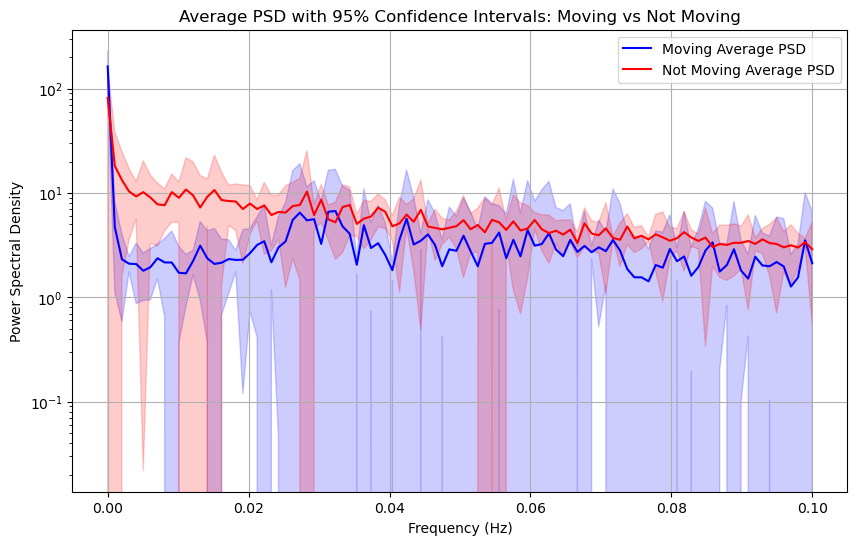

In [13]:
target_freqs = np.linspace(0, 0.1, num=100)
moving_resampled_psds = resample_psd_to_common_freq(moving_data, target_freqs)
notmoving_resampled_psds = resample_psd_to_common_freq(notmoving_data, target_freqs)
mean_moving_resampled_psd, sem_moving_resampled_psd = calculate_mean_sem(
    moving_resampled_psds
)
mean_notmoving_resampled_psd, sem_notmoving_resampled_psd = calculate_mean_sem(
    notmoving_resampled_psds
)

# Calculate the confidence interval for the mean PSD values
ci_moving_resampled_psd = confidence_interval(moving_resampled_psds)
ci_notmoving_resampled_psd = confidence_interval(notmoving_resampled_psds)

# Plotting
plt.figure(figsize=(10, 6))

# Plot mean PSD
plt.plot(
    target_freqs, mean_moving_resampled_psd, label="Moving Average PSD", color="blue"
)
plt.plot(
    target_freqs,
    mean_notmoving_resampled_psd,
    label="Not Moving Average PSD",
    color="red",
)

# Add shaded confidence interval around the mean PSD
plt.fill_between(
    target_freqs,
    mean_moving_resampled_psd - ci_moving_resampled_psd,
    mean_moving_resampled_psd + ci_moving_resampled_psd,
    color="blue",
    alpha=0.2,
)
plt.fill_between(
    target_freqs,
    mean_notmoving_resampled_psd - ci_notmoving_resampled_psd,
    mean_notmoving_resampled_psd + ci_notmoving_resampled_psd,
    color="red",
    alpha=0.2,
)

plt.title("Average PSD with 95% Confidence Intervals: Moving vs Not Moving")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectral Density")
plt.legend()
plt.grid(True)
plt.yscale("log")
plt.show()